# Modeling a DHN as a single pipe

![image](dhn_single_pipe.svg)

$\Delta T$ mean differences to ambient temperature $T_{env}$. 


\begin{equation*}
\dot{Q}_{prod} = c\dot{m} \hspace{3pt} (\Delta T_{prod,in} - \Delta T_{prod,r}) \\
\dot{Q}_{cons} = c\dot{m} \hspace{3pt} (\Delta T_{cons,r} - \Delta T_{cons,in}) \\
\dot{Q}_{loss,in} = c\dot{m} \hspace{3pt} (\Delta T_{cons,in} - \Delta T_{prod,in}) = c\dot{m} \Delta T_{prod,in} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}\\
\dot{Q}_{loss,r} = c\dot{m} \hspace{3pt} (\Delta T_{prod,r} - \Delta T_{cons,r}) = c\dot{m} \Delta T_{cons,r} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}\\
\dot{Q}_{prod} + \dot{Q}_{cons} + \dot{Q}_{loss,in} + \dot{Q}_{loss,r} = 0 \\
P_{el,pump} = \frac{1}{\eta}\frac{\Delta p }{\rho} \dot{m}
\end{equation*}

The following assumptions are made:
1. $\dot{Q}_{cons}$ is known
2. $\Delta T_{prod,in}$ is given by the Heizkurve
3. $\Delta T_{cons,in} - \Delta T_{cons,r} = \Delta T_{drop}$ is known

It follows from 1. that:

\begin{equation}
\dot{m} = \frac{\dot{Q}_{cons}}{c\Delta T_{drop}}.
\end{equation}

Together with 2., the mass flow is fixed. Next, the inlet temperature at the consumer is determined by:

\begin{equation}
\Delta T_{cons,in} = \Delta T_{prod,in} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}
\end{equation}

The return temperature at the consumer is given by 3. Again, the return temperature at the producer is reduced by losses on the return line:

\begin{equation}
\Delta T_{prod,r} = \Delta T_{cons,r} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}
\end{equation}

We are interested in $\dot{Q}_{prod}$. It can be determined by

\begin{equation}
\dot{Q}_{prod} = c\dot{m} (\Delta T_{prod,in} - \Delta T_{prod,r}).
\end{equation}

We insert above equations and finally get:

\begin{equation}
\dot{Q}_{prod} = \dot{Q}_{prod}(\dot{Q}_{cons}) = \dot{Q}_{cons} \frac{1}{\Delta T_{drop}}(\Delta T_{prod,in}(1- exp \{-2\frac{k\pi LD}{c\dot{m}}\}) + \Delta T_{drop} exp \{-\frac{k\pi LD}{c\dot{m}}\}) \\
P_{el,pump} = P_{el,pump}(\dot{Q}_{cons}) = 
\end{equation}

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
   
def single_pipe(Q_cons, DT_drop,
                DT_prod_in,
                k, L, D, c,
                rho, eps, mu):
    r"""
    
    
    """
    Q_cons *= 1e6 # MW to W
    
    # hydraulic part
    # mass flow is determined by consumer mass flow
    m = Q_cons * 1 /(c*DT_drop)
    
    # pressure loss
    v = 4*m / (rho * np.pi * D**2)
    Re = D * v * rho / mu
    print(Re)
    lamb = 1.325 / (np.log(eps/(3.7*D) + 5.74/(Re**0.9)))**2
    
    pressure_loss = lamb2 * 8*L * 1/(rho*np.pi**2*D**5) * m**2
    Dp_pump = 2 * pressure_loss
    P_pump = Dp_pump * m * 1/rho

    # heat losses in feedin and return pipe
    exponent = k * np.pi * L * D * 1/(c*m)
    DT_cons_in = DT_prod_in * np.exp(-1*exponent)
    print('DT_cons_in', DT_cons_in)
    DT_prod_r = (DT_cons_in - DT_drop) *  np.exp(-1*exponent)
    print('DT_prod_r', DT_prod_r)
    
    Q_prod = c * m * (DT_prod_in - DT_prod_r)
    Q_loss = Q_prod - Q_cons
    
    if DT_prod_r > 0:
        return {'Q_prod': Q_prod, # W
                'DT_cons_in': DT_cons_in, # K
                'DT_prod_r': DT_prod_r, # K
                'm': m, # kg/s
                'pressure_loss': pressure_loss, # Pa
                'P_pump': P_pump, # W
                'Q_loss': Q_loss} # W
    else:
        return None

Rohrdurchmesser und Beschaffenheit, Druckverluste, Massenstrom und Pumpleistung



In [242]:
DT_prod_in = 80 # Kelvin, from Heizkurve
DT_drop = 10 # Kelvin
k = 1.5 # W/(m^2 * K) 
L = 1000 #m 
c = 4230 # J/(kg*K) at 20°C
rho = 951 # kg/m3
eps = 0.01 #m
mu = 0.255e-3 

D = 0.25 # m

# Verschiedene Wärmenachfragen
dic = {'Q_cons [MW]': np.arange(1, 6, 0.2),
      'pressure_loss [bar]': [],
      'mass_flow [kg/s]': [],
      'Q_prod [MW]': [],
      'Q_loss [MW]': [],
      'P_pump [kW]': []}

for q in dic['Q_cons [MW]']:
    results = single_pipe(q, DT_drop, DT_prod_in,
                          k, L, D, c, rho, eps, mu)
    
    dic['pressure_loss [bar]'].append(results['pressure_loss'] * 1e-5)
    dic['P_pump [kW]'].append(results['P_pump'] * 1e-3)
    dic['mass_flow [kg/s]'].append(results['m'])
    dic['Q_prod [MW]'].append(results['Q_prod'] * 1e-6)
    dic['Q_loss [MW]'].append(results['Q_loss'] * 1e-6)

df = pd.DataFrame(dic)
df = df.set_index('Q_cons [MW]')

df['velocity_flow [m/s]'] = 4  * df['mass_flow [kg/s]'] / (rho * np.pi * D**2)
df['loss_perc'] = df['Q_loss [MW]'] * 1/df['Q_prod [MW]']
df

472160.4022565847
DT_cons_in 79.06305211916948
DT_prod_r 68.2541961150852
566592.4827079016
DT_cons_in 79.21844456524026
DT_prod_r 68.54221892104553
661024.5631592186
DT_cons_in 79.32962612159403
DT_prod_r 68.74866649219943
755456.6436105354
DT_cons_in 79.41311467890333
DT_prod_r 68.90389545269522
849888.7240618523
DT_cons_in 79.47811096527849
DT_prod_r 69.0248626619542
944320.8045131692
DT_cons_in 79.5301462939278
DT_prod_r 69.12178383242849
1038752.884964486
DT_cons_in 79.57274599270293
DT_prod_r 69.2011805611524
1133184.9654158032
DT_cons_in 79.60826317172872
DT_prod_r 69.26741166877416
1227617.0458671201
DT_cons_in 79.63832855133944
DT_prod_r 69.32350111172116
1322049.1263184373
DT_cons_in 79.66410791396288
DT_prod_r 69.37161263234867
1416481.2067697537
DT_cons_in 79.68645677825306
DT_prod_r 69.41333532612329
1510913.2872210706
DT_cons_in 79.70601717757742
DT_prod_r 69.44986253170616
1605345.3676723877
DT_cons_in 79.72328034076307
DT_prod_r 69.48210781105335
1699777.4481237046
DT_c

,pressure_loss [bar],mass_flow [kg/s],Q_prod [MW],Q_loss [MW],P_pump [kW],velocity_flow [m/s],loss_perc
Q_cons [MW],,,,,,,
1.0,0.084727,23.640662,1.174580,0.174580,0.421239,0.506418,0.148632
1.2,0.122006,28.368794,1.374934,0.174934,0.727901,0.607702,0.127231
1.4,0.166064,33.096927,1.575187,0.175187,1.155880,0.708985,0.111216
1.6,0.216900,37.825059,1.775377,0.175377,1.725395,0.810269,0.098783
1.8,0.274514,42.553191,1.975525,0.175525,2.456666,0.911553,0.088850
2.0,0.338906,47.281324,2.175643,0.175643,3.369912,1.012836,0.080732
2.2,0.410076,52.009456,2.375740,0.175740,4.485353,1.114120,0.073973
2.4,0.488025,56.737589,2.575821,0.175821,5.823208,1.215403,0.068258
2.6,0.572751,61.465721,2.775890,0.175890,7.403697,1.316687,0.063363


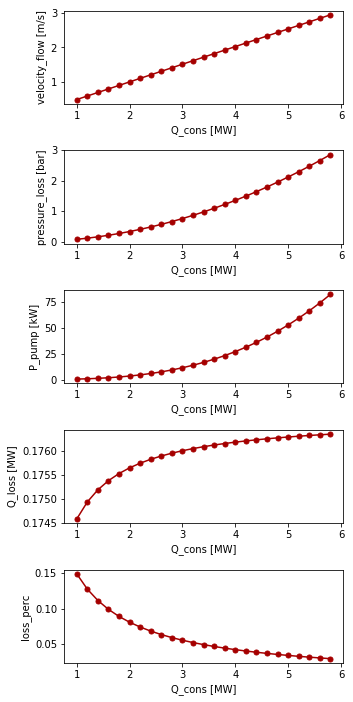

In [244]:
fig, axs = plt.subplots(5, 1, figsize=(5,12))
for i, c in enumerate(['velocity_flow [m/s]',
                       'pressure_loss [bar]',
                       'P_pump [kW]',
                       'Q_loss [MW]',
                       'loss_perc',]):
    df[c].plot(ax=axs[i], marker='.',
               markersize=10, color='#a50000')
    axs[i].set_xlabel('Q_cons [MW]')
    axs[i].set_ylabel(c)
plt.subplots_adjust(hspace=0.5)

Temperaturspreizung

Wärmeverluste

Kosten (Pumpkosten + Wärmekosten)

Bei versch. Außentemperaturen  
Bei verschiedenen Temperaturniveaus

e/d 4e-05


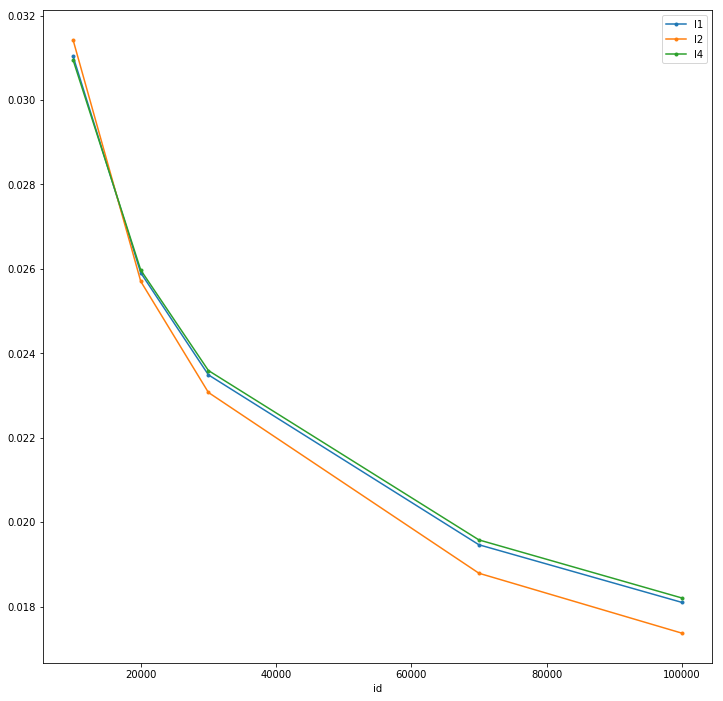

In [135]:
eps = 0.01*1e-3
D = 0.25
print('e/d', eps/D)
lam = {'id': [],
       'l0': [],
       'l1': [],
       'l2': [],
       'l3': [],
       'l4': []}
for Re in ([10000,20000,30000,70000,100000]):
    lamb0 = 0.07 * Re**(-0.13) * D**(-0.14)
    lamb1 = 1.325 / (np.log(eps/(3.7*D) + 5.74/(Re**0.9)))**2
    lamb2 = 0.25 * 1/(np.log10(15/Re + eps/(3.715*D)))**2
    lamb3 = 0.25 / (np.log10(eps/(3.7*D) + 5.74/(Re**0.9)))**2
    
    def f(x):
        return (-2*np.log10((2.51/(Re*np.sqrt(x))) + (eps/(3.71*D))) - 1.0/np.sqrt(x))
    lamb4 = root(f, 0.0002)['x'][0]
    
    lam['id'].append(Re)
    lam['l0'].append(lamb0)
    lam['l1'].append(lamb1)
    lam['l2'].append(lamb2)
    lam['l3'].append(lamb3)
    lam['l4'].append(lamb4)
ll = pd.DataFrame(lam)
ll = ll.set_index('id')
fig, ax = plt.subplots(figsize=(12,12))
ll[['l1', 'l2', 'l4']].plot(marker='.', ax=ax)

In [162]:
ll

,l0,l1,l2,l3,l4
id,,,,,
10000,0.025668,0.031032,0.031419,0.031043,0.030945
20000,0.023456,0.025905,0.025703,0.025914,0.025971
30000,0.022252,0.023489,0.023072,0.023497,0.023591
70000,0.019931,0.019463,0.018789,0.019470,0.019578
100000,0.019028,0.018098,0.017370,0.018105,0.018203


In [205]:
0.264/(np.pi*0.02)

4.2016904976260365

In [208]:
df = pd.DataFrame()
df['DN'] = np.array([0.025, 0.032, 0.040, 0.050, 0.160])
df['Uspez'] = np.array([0.264, 0.312, 0.322, 0.341, 0.511])
df['U'] = df['Uspez'] * 1/(2* np.pi * df['DN'])

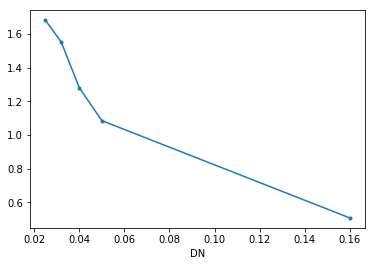

In [209]:
df = df.set_index('DN')
df['U'].plot(marker='.')

In [526]:
def single_pipe(args):
    r"""
    
    
    """
    Q_cons, DT_drop, DT_prod_in, k, L, D, c, rho, eps, mu = args
    Q_cons *= 1e6 # MW to W
    
    # hydraulic part
    # mass flow is determined by consumer mass flow
    m = Q_cons * 1 /(c*DT_drop)
    
    # pressure loss
    v = 4*m / (rho * np.pi * D**2)
    Re = D * v * rho / mu
    lamb = 1.325 / (np.log(eps/(3.7*D) + 5.74/(Re**0.9)))**2
    
    pressure_loss = lamb2 * 8*L * 1/(rho*np.pi**2*D**5) * m**2
    print(pressure_loss)
    Dp_pump = 2 * pressure_loss
    P_pump = Dp_pump * m * 1/rho

    # heat losses in feedin and return pipe
    exponent = k * np.pi * L * D * 1/(c*m)
    DT_cons_in = DT_prod_in * np.exp(-1*exponent)
    DT_prod_r = (DT_cons_in - DT_drop) *  np.exp(-1*exponent)
    
    Q_prod = c * m * (DT_prod_in - DT_prod_r)
    Q_loss = Q_prod - Q_cons
    perc_loss = Q_loss * 1/Q_prod
    
    if DT_prod_r > 0:
        return np.array([Q_prod, DT_cons_in, DT_prod_r, m, 
                         pressure_loss, P_pump, Q_loss, perc_loss])
    else:
        return None

In [537]:
def generic_sampling(input_dict, results_dict, function):
    r"""
    n-dimensional full sampling, storing as xarray.
    
    Parameters
    ----------
    input_dict : OrderedDict
        Ordered dictionary containing the ranges of the
        dimensions.
    
    results_dict : OrderedDict
        Ordered dictionary containing the dimensions and 
        coordinates of the results of the function.
        
    function : function
        Function to be sampled.
    
    Returns
    -------
    results : xarray.DataArray
    
    sampling : np.array
    
    indices : 
    """
    import itertools as it
    join_dicts = OrderedDict(list(input_dict.items()) + list(results_dict.items()))
    dims = join_dicts.keys()
    coords = join_dicts.values()
    results = xr.DataArray(np.empty([len(v) for v in join_dicts.values()]),
                           dims=dims,
                           coords=coords)

    sampling = np.array(list(it.product(*input_dict.values())))
    indices = np.array(list(it.product(*[np.arange(len(v)) for v in input_dict.values()])))
    
    for i in range(len(sampling)):
        result = function(sampling[i])
        results[tuple(indices[i])] = result
        
    return results, sampling, indices

from collections import OrderedDict
import xarray as xr

input_dict = OrderedDict([('Q_cons', np.arange(1, 6, 0.2)),
                          ('DT_drop', [10]),
                          ('DT_prod_in', [70,80,90,100,110]),
                          ('k', np.arange(1, 4, 0.1)),
                          ('L', [1000]),
                          ('D', [0.25, 0.3, 0.4, 0.5]),
                          ('c', [4230]),
                          ('rho', [951]),
                          ('eps', [0.01]),
                          ('mu', [0.255e-3])])

result_dict_scalar = OrderedDict()

result_dict_vector = OrderedDict([('results', ['Q_prod',
                                               'DT_cons_in',
                                               'DT_prod_r',
                                               'm',
                                               'pressure_loss',
                                               'P_pump',
                                               'Q_loss',
                                               'perc_loss'])])

result_dict_array = OrderedDict([('time', np.arange(0,8,2)),
                                ('lat', np.arange(0,8,4))])

result_dict_cube = OrderedDict([('time', np.arange(0,9,3)),
                                ('lat', np.arange(0,8,2)),
                                ('lon', np.arange(0,15,3))])

sam_results = generic_sampling(input_dict, result_dict_vector, 
                          single_pipe)[0]

8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.65420547021
3404.969700629426
808.015270754834
264.77044392094405
8472.6

381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.622055877102
4903.156368906372
1163.5419898869607
381.26943924615944
12200.

518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.4

16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7406132336755
1583.7099306794746
518.9500700850505
16606.402242721615
6673.7

677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8716.722433611329
2068.5190931323746
677.8123364376168
21689.994766003736
8

857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
11032.101830039335
2617.969477245661
857.8562383038585
27451.399625723472
1

33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.0817756837762
33890.61682188084
13619.8788025177
3232.061083019335
1059.081775

16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943
1281.4889485773688
41007.6463544758
16480.053351046412
3910.7939104533943


19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1525.0777569846373
48802.48822350839
19612.625475625486
4654.167959547842
1

5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.1424289786
23017.595176254912
5462.183230302676
1789.8482009055813
57275.14242897

26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340202
66425.60897088646
26694.962452934702
6334.839722717898
2075.800280340

76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.137436793502
2382.9339952884957
76253.88784923186
30644.72730566482
7272.1374367935

2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2493457504656
86759.9790640149
34866.8897344453
8274.076372529495
2711.2

97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.7463317261127
97943.8826152356
39361.44973927615
9340.656529925878
3060.746331

109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
10471.877908982644
3431.424953215434
109805.59850289389
44128.40732015734
1

122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11667.740509699799
3823.2852102184315
122345.12672698981
49167.7624770889
11

54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735103
135562.4672875233
54479.51521007078
12928.244332077335
4236.327102735

60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4670.550630765452
149457.62018449447
60063.66551910305
14253.389376115267
4

5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.21340418565
15643.175641813577
5125.955794309475
164030.5854179032
65920.213404185

179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
17097.603129172287
5602.542593367177
179281.36298774966
72049.15886531865
1

6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
78450.50190250194
18616.671838191367
6100.311027938549
195209.95289403357
7

211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.38176887084
6619.2610980235995
211816.35513675518
85124.2425157356
20200.381768870

23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.725295210945
7720.706144734725
247062.5966315112
99288.916470354
23561.

8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
106779.84981173876
25339.358890871586
8303.201121360804
265702.4358835457
10

8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.18072917384
27181.6337081926
8906.877733500554
285020.08747201774
114543.1807291

In [538]:
sam_results.coords

Coordinates:
  * Q_cons      (Q_cons) float64 1.0 1.2 1.4 1.6 1.8 2.0 ... 5.0 5.2 5.4 5.6 5.8
  * DT_drop     (DT_drop) int64 10
  * DT_prod_in  (DT_prod_in) int64 70 80 90 100 110
  * k           (k) float64 1.0 1.1 1.2 1.3 1.4 1.5 ... 3.4 3.5 3.6 3.7 3.8 3.9
  * L           (L) int64 1000
  * D           (D) float64 0.25 0.3 0.4 0.5
  * c           (c) int64 4230
  * rho         (rho) int64 951
  * eps         (eps) float64 0.01
  * mu          (mu) float64 0.000255
  * results     (results) <U13 'Q_prod' 'DT_cons_in' ... 'Q_loss' 'perc_loss'

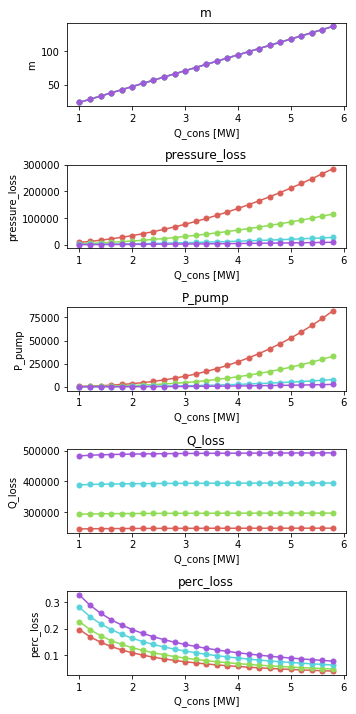

In [539]:
fig, axs = plt.subplots(5, 1, figsize=(5,12))
import seaborn as sns
colors = sns.color_palette("hls", len(sam_results['D'])).as_hex()
for i, c in enumerate(['m',
                       'pressure_loss',
                       'P_pump',
                       'Q_loss',
                      'perc_loss']):
#     for i_k in [0, 1, 2]:
#         sam_results.squeeze() \
#         .isel(k=i_k, D=1, DT_prod_in=-1) \
#         .sel(results=c) \
#         .plot(ax=axs[i], marker='.', markersize=10, color='#a50000')
        
    for ii, vv in enumerate(sam_results.coords['D'].values):
        sam_results.squeeze() \
        .isel(k=5, DT_prod_in=-1) \
        .sel(results=c, D=vv) \
        .plot(ax=axs[i], marker='.', markersize=10, color=colors[ii])

    axs[i].set_xlabel('Q_cons [MW]')
    axs[i].set_ylabel(c)
    axs[i].set_title(c)
plt.subplots_adjust(hspace=0.7)

In [533]:
sam_results.squeeze() \
.isel(k=5, DT_prod_in=-1) \
.sel(results='P_pump', D=0.1)

<xarray.DataArray (Q_cons: 25)>
array([  41136.623002,   71084.084548,  112878.893519,  168495.607818,
        239908.78535 ,  329092.984019,  438022.76173 ,  568672.676386,
        723017.285891,  903031.148149, 1110688.821066, 1347964.862544,
       1616833.830488, 1919270.282802, 2257248.77739 , 2632743.872156,
       3047730.125004, 3504182.09384 , 4004074.336565, 4549381.411085,
       5142077.875305, 5784138.287127, 6477537.204456, 7224249.185196,
       8026248.787251])
Coordinates:
  * Q_cons      (Q_cons) float64 1.0 1.2 1.4 1.6 1.8 2.0 ... 5.0 5.2 5.4 5.6 5.8
    DT_drop     int64 10
    DT_prod_in  int64 110
    k           float64 1.5
    L           int64 1000
    D           float64 0.1
    c           int64 4230
    rho         int64 951
    eps         float64 0.01
    mu          float64 0.000255
    results     <U13 'P_pump'